In [1]:
import os
import codecs
import re

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [7]:
np.random.seed(0)

In [8]:
languages = set(['EN', 'JP'])
data_train = {language: None for language in languages}
data_validation = {language: None for language in languages}
emb_matrix = {language: None for language in languages}

In [9]:
dim_seq = {language: None for language in languages}
dim_vocab = {language: None for language in languages}
dim_emb =  {language: 300 for language in languages}
tokenizer = {language: None for language in languages}

In [10]:
detokenizer = {language: None for language in languages}

In [11]:
# Data Preparation

In [12]:
def tokenize(lines):
    tokenizer = Tokenizer(filters="")
    whole_texts = []
    for line in lines:
        whole_texts.append("<s> " + line.strip() + " </s>")
        
    tokenizer.fit_on_texts(whole_texts)
    
    return tokenizer.texts_to_sequences(whole_texts), tokenizer

In [13]:
# path_input = './Data/22/output/corpus.csv'
path_input = '/root/userspace/private/FinalExam/Data/070/input/'
path_output = '/root/userspace/private/FinalExam/Data/070/output'

In [14]:
files = os.listdir(path_input)

df = pd.DataFrame()

for i, file in enumerate(files):
    print('{0:02d}/{1:02d}: {2}'.format(i+1, len(files), file))
    
    if re.match('\..*', file):
        print('Incorrect file: {0}\n'.format(file))
        continue
    elif os.path.isdir(path_input + file):
        print('Directory {0}\n'.format(file))
        continue
    
    print('Loading corpus data')
    df_claims = pd.read_csv(path_input + file)
    
    print('\n')
    print(df_claims.info())
    print('\n')
    
    print('Concatenating data frame')
    df = pd.concat([df, df_claims])
    print('Concatenating data frame is finished\n')

01/09: corpus_03.csv
Loading corpus data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15709 entries, 0 to 15708
Data columns (total 4 columns):
id_doc      15709 non-null object
id_claim    15709 non-null int64
claim_JP    15709 non-null object
claim_EP    15709 non-null object
dtypes: int64(1), object(3)
memory usage: 491.0+ KB
None


Concatenating data frame
Concatenating data frame is finished

02/09: corpus_07.csv
Loading corpus data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18847 entries, 0 to 18846
Data columns (total 4 columns):
id_doc      18847 non-null object
id_claim    18847 non-null int64
claim_JP    18847 non-null object
claim_EP    18847 non-null object
dtypes: int64(1), object(3)
memory usage: 589.0+ KB
None


Concatenating data frame
Concatenating data frame is finished

03/09: corpus_05.csv
Loading corpus data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17862 entries, 0 to 17861
Data columns (total 4 columns):
id_doc      17862 non-null object

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134553 entries, 0 to 14386
Data columns (total 4 columns):
id_doc      134553 non-null object
id_claim    134553 non-null int64
claim_JP    134553 non-null object
claim_EP    134553 non-null object
dtypes: int64(1), object(3)
memory usage: 5.1+ MB


In [16]:
df['length_JP'] = df['claim_JP'].map(len)
df['length_EP'] = df['claim_EP'].map(len)

In [17]:
df['length_EP'].describe()

count    134553.000000
mean        311.258508
std         269.123036
min          12.000000
25%         154.000000
50%         227.000000
75%         360.000000
max        4244.000000
Name: length_EP, dtype: float64

In [18]:
df['length_JP'].describe()

count    134553.000000
mean        164.139202
std         131.718730
min          17.000000
25%          88.000000
50%         124.000000
75%         189.000000
max        2148.000000
Name: length_JP, dtype: float64

In [19]:
df = df[df['length_EP'] < df['length_EP'].describe()['75%']]

In [20]:
df = df[df['length_JP'] < df['length_JP'].describe()['75%']]

In [21]:
df = df[df['length_EP'] < df['length_EP'].describe()['75%']]

In [22]:
df = df[df['length_JP'] < df['length_JP'].describe()['75%']]

In [23]:
df = df[df['length_EP'] < df['length_EP'].describe()['75%']]

In [24]:
df['length_EP'].describe()

count    31590.000000
mean       117.127952
std         23.144656
min         30.000000
25%        100.000000
50%        119.000000
75%        136.000000
max        154.000000
Name: length_EP, dtype: float64

In [25]:
df['length_JP'].describe()

count    31590.000000
mean        68.378791
std         14.823603
min         17.000000
25%         58.000000
50%         69.000000
75%         79.000000
max         97.000000
Name: length_JP, dtype: float64

In [26]:
df_columns = {'EN': 'claim_EP', 'JP': 'claim_JP'}

In [27]:
for language in languages:
    data_train[language], tokenizer[language] = tokenize(df[df_columns[language]].tolist())
    dim_vocab[language] = len(tokenizer[language].word_index) + 1
    print('{0} vocab size: {1}'.format(language, dim_vocab[language]))

EN vocab size: 10264
JP vocab size: 8301


In [28]:
data_train['EN'], data_validation['EN'], data_train['JP'], data_validation['JP'] = train_test_split(
                                                                                       data_train['EN'],
                                                                                       data_train['JP'],
                                                                                       test_size=0.01,
                                                                                       random_state=42
                                                                                   )

In [29]:
for language in languages:
    data_train[language] = pad_sequences(data_train[language], padding='post')
    dim_seq[language] = len(data_train[language][0])
    print('Dim {0} sequence: {1}'.format(language, dim_seq[language]))

Dim EN sequence: 41
Dim JP sequence: 47


In [30]:
# Creating embedding matrix

In [31]:
#path_input_wvec = {'EN': 'Data/20/output/wvec/EN/',
#                   'JP': 'Data/20/output/wvec/JP/'}
path_input_wvec = {'EN': '/root/userspace/private/FinalExam/Data/070/input/wvec/EN/',
                   'JP': '/root/userspace/private/FinalExam/Data/070/input/wvec/JP/'}

In [32]:
for language in languages:
    print('Extracting {0} emb vectors'.format(language))
    
    emb_matrix[language] = np.zeros(shape=(dim_vocab[language], dim_emb[language]), dtype=np.float32)
    
    files = os.listdir(path_input_wvec[language])
    for file in files:
        fin = codecs.open(path_input_wvec[language]+file, 'r', 'utf-8')
        for line in fin:
            tokens = line.rstrip().split(' ')
            if tokens[0] in tokenizer[language].word_index.keys():
                emb_matrix[language][tokenizer[language].word_index[tokens[0]]] = tokens[1:]

Extracting EN emb vectors
Extracting JP emb vectors


In [33]:
vector_bos = np.zeros(shape=(dim_emb[language]), dtype=np.float32)
vector_bos[0] = 1.0 
vector_eos = np.zeros(shape=(dim_emb[language]), dtype=np.float32)
vector_eos[dim_emb[language]-1] = 1.0 

for language in languages:
    emb_matrix[language][tokenizer[language].word_index['<s>']] = vector_bos
    emb_matrix[language][tokenizer[language].word_index['</s>']] = vector_eos

In [34]:
# Building a model

In [35]:
class RNNEncoderDecoderAtt(object):
    def __init__(self,
                 dim_input_seq,
                 dim_input_vocab,
                 dim_output_seq,
                 dim_output_vocab,
                 dim_emb,
                 dim_hid, 
                 dim_att,
                 emb_matrix_input,
                 emb_matrix_output):
        
        self.dim_input_seq = dim_input_seq
        self.dim_input_vocab = dim_input_vocab
        
        self.dim_output_seq = dim_output_seq
        self.dim_output_vocab = dim_output_vocab
        
        self.dim_emb = dim_emb
        self.dim_hid = dim_hid
        self.dim_att = dim_att
        
        self.emb_matrix_input = emb_matrix_input
        self.emb_matrix_output = emb_matrix_output
        
        # Model
        self._model = None
        self._model_validation_encoder = None
        self._model_validation_decoder = None
        self._model_validation_attention = None
                
        # Encoder 
        self._num_encoder_bidirectional_layers = 2
        
        ## Layer
        self._encoder_inputs = None
        
        ## Tensor
        self._encoded_seq = None
        self._encoder_states = []
        
        # Decoder
        self._num_decoder_RNN_layers = 2
        
        ## Layer
        self._decoder_embedding = None
        self._decoder_lstm = []
        self._decoder_dense = None

        # Attension
        ## Layer
        self._attention_score_dense = None
        self._attention_dense = None
        
        # Output
        ## Layer
        self._output_dense = None
        
    def inference(self):
        from keras.models import Model
        from keras.layers import Input, Embedding, Dense, LSTM, concatenate, dot, add, Activation
        
        # Encoder
        ## Input Layer
        self._encoder_inputs = Input(shape=(self.dim_input_seq,))

        ## Embedding Layer
        encoded_seq_fwd = Embedding(self.dim_input_vocab,
                                    self.dim_emb,
                                    weights=[self.emb_matrix_input],
                                    mask_zero=True,
                                    trainable=False)(self._encoder_inputs) # (dim_seq_input,)->(dim_seq_input, dim_emb)
        
        encoded_seq_bwd = Embedding(self.dim_input_vocab,
                                    self.dim_emb,
                                    weights=[self.emb_matrix_input],
                                    mask_zero=True,
                                    trainable=False)(self._encoder_inputs) # (dim_seq_input,)->(dim_seq_input, dim_emb)
        
        ## LSTM Layer
        for i in range(self._num_encoder_bidirectional_layers):
            encoded_seq_fwd, *encoder_states_fwd = LSTM(self.dim_hid, return_sequences=True, return_state=True)(encoded_seq_fwd)  # (dim_seq_input, dim_emb)->(dim_seq_input, dim_hid)
            encoded_seq_bwd, *encoder_states_bwd = LSTM(self.dim_hid, return_sequences=True, return_state=True, go_backwards=True)(encoded_seq_bwd)
            
            self._encoder_states.append([add([encoder_states_fwd[j], encoder_states_bwd[j]]) for j in range(len(encoder_states_fwd))])
            
        self._encoded_seq = add([encoded_seq_fwd, encoded_seq_bwd])
        
        # Decoder
        ## Instance
        self._decoder_embedding = Embedding(self.dim_output_vocab,
                                            self.dim_emb,
                                            weights=[self.emb_matrix_output],
                                            trainable=False)
        
        for i in range(self._num_decoder_RNN_layers):
            self._decoder_lstm.append(LSTM(self.dim_hid, return_sequences=True, return_state=True))
        
        ## Input Layer
        decoder_inputs = Input(shape=(self.dim_output_seq,))

        ## Embedding Layer
        decoded_seq = self._decoder_embedding(decoder_inputs)  # (dim_seq_output,)->(dim_seq_output, dim_emb)
        
        ## LSTM Layer
        for i in range(self._num_decoder_RNN_layers):
            decoded_seq, _, _ = self._decoder_lstm[i](decoded_seq, initial_state=self._encoder_states[i]) # (dim_seq_output, dim_emb)->(dim_seq_output, dim_hid)
        
        # Attention
        ## Instance
        self._attention_score_dense = Dense(self.dim_hid)
        self._attention_dense = Dense(self.dim_att, activation='tanh')
        
        ## Attention
        score = self._attention_score_dense(decoded_seq)        # (dim_seq_output, dim_hid) -> (dim_seq_output, dim_hid)
        score = dot([score, self._encoded_seq], axes=(2,2))           # [(dim_seq_output, dim_hid), (dim_seq_input, dim_hid)] -> (dim_seq_output, dim_seq_input)
        attention = Activation('softmax')(score)                # (dim_seq_output, dim_seq_input) -> (dim_seq_output, dim_seq_input)

        ## Context
        context = dot([attention, self._encoded_seq], axes=(2,1))     # [(dim_seq_output, dim_seq_input), (dim_seq_input, dim_hid)] -> (dim_seq_output, dim_hid)
        concat = concatenate([context, decoded_seq], axis=2)    # [(dim_seq_output, dim_hid), (dim_seq_output, dim_hid)] -> (dim_seq_output, 2*dim_hid)
        attentional = self._attention_dense(concat)             # (dim_seq_output, 2*hid_dim) -> (dim_seq_output, dim_att)
        
        # Output Layer
        ## Instance
        self._output_dense = Dense(self.dim_output_vocab, activation='softmax')
        
        ## Output
        predictions = self._output_dense(attentional)  # (dim_seq_output, dim_att) -> (dim_seq_output, dim_vocab_output)
        
        return Model([self._encoder_inputs, decoder_inputs], predictions)
    
    def inference_validation(self):
        from keras.models import Model
        from keras.layers import Input, dot, concatenate, Activation

        # Encoder
        model_encoder = Model([self._encoder_inputs], [self._encoded_seq]+self._encoder_states[0]+self._encoder_states[1])

        # Decoder
        decoder_inputs = Input(shape=(1,))

        decoder_inputs_states = []
        for i in range(self._num_decoder_RNN_layers):
            decoder_inputs_states.append([Input(shape=(self.dim_hid,)), Input(shape=(self.dim_hid,))])

        decoded_seq = self._decoder_embedding(decoder_inputs)

        decoder_states = [None for i in range(self._num_decoder_RNN_layers)]
        for i in range(self._num_decoder_RNN_layers):
            decoded_seq, *decoder_states[i] = self._decoder_lstm[i](decoded_seq, initial_state=decoder_inputs_states[i])

        model_decoder = Model([decoder_inputs] + decoder_inputs_states[0] + decoder_inputs_states[1], [decoded_seq] + decoder_states[0] + decoder_states[1])

        # Attention
        encoded_seq_in = Input(shape=(self.dim_input_seq, self.dim_hid))
        decoded_seq_in = Input(shape=(1, self.dim_hid))

        ## Score
        score = self._attention_score_dense(decoded_seq_in)
        score = dot([score, encoded_seq_in], axes=(2,2))
        attention = Activation('softmax')(score)

        ## Context
        context = dot([attention, encoded_seq_in], axes=(2,1))
        concat = concatenate([context, decoded_seq_in], axis=2)
        attentional = self._attention_dense(concat)

        # Output Layer
        predictions = self._output_dense(attentional)

        model_attention = Model([encoded_seq_in, decoded_seq_in], predictions)

        return model_encoder, model_decoder, model_attention
               
    def predict(self, X, bos_eos, max_output_length = 100):
        states_value = [None for i in range(self._num_encoder_bidirectional_layers)]

        encoded_seq, *states_value = self._model_validation_encoder.predict(X)

        target_seq = np.array(bos_eos[0])
        output_seq = bos_eos[0][:]

        while True:
            decoded_seq, *states_value = self._model_validation_decoder.predict([target_seq] + states_value)
            output_tokens = self._model_validation_attention.predict([encoded_seq, decoded_seq])
            sampled_token_index = [np.argmax(output_tokens[0, -1, :])]
            output_seq += sampled_token_index

            if (sampled_token_index == bos_eos[1] or len(output_seq) > max_output_length):
                break

            target_seq = np.array(sampled_token_index)

        return output_seq

    def compile(self):
        self._model = self.inference()
        self._model.compile(loss='sparse_categorical_crossentropy',
                            optimizer='rmsprop',
                            metrics=['accuracy'])
        
        self._model_validation_encoder, self._model_validation_decoder, self._model_validation_attention = self.inference_validation()

    def fit(self, X_train, Y_train, epochs, batch_size, verbose=1):
        train_target = np.hstack((Y_train[:, 1:], np.zeros((len(Y_train),1), dtype=np.int32)))
        
        history = self._model.fit([X_train, Y_train],
                                  np.expand_dims(train_target, -1),
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=verbose,
                                  validation_split=0.1)
        
        return history.history
    
    def show_graph(self):
        return model_to_dot(self._model).create(prog='dot', format='svg')

In [36]:
model = RNNEncoderDecoderAtt(dim_input_seq=dim_seq['EN'],
                             dim_input_vocab=dim_vocab['EN'],
                             dim_output_seq=dim_seq['JP'],
                             dim_output_vocab=dim_vocab['JP'],
                             dim_emb=dim_emb['EN'],
                             dim_hid=256,
                             dim_att=256,
                             emb_matrix_input=emb_matrix['EN'],
                             emb_matrix_output=emb_matrix['JP'])

In [37]:
model.compile()

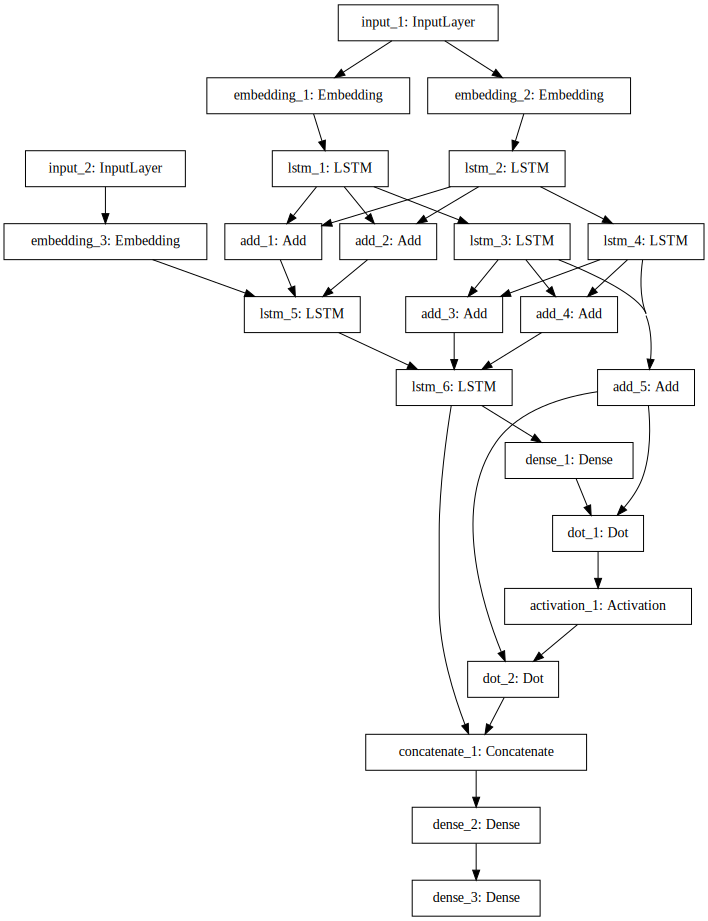

In [38]:
SVG(model.show_graph())

In [39]:
# Training the model

In [41]:
history = model.fit(data_train['EN'],
                    data_train['JP'],
                    epochs=10,
                    batch_size=32*7)

Train on 28146 samples, validate on 3128 samples
Epoch 1/10
28146/28146 [==============================] - 264s 9ms/step - loss: 3.2362 - acc: 0.4644 - val_loss: 2.5413 - val_acc: 0.5404
Epoch 2/10
28146/28146 [==============================] - 260s 9ms/step - loss: 2.2210 - acc: 0.6070 - val_loss: 1.9416 - val_acc: 0.6726
Epoch 3/10
28146/28146 [==============================] - 261s 9ms/step - loss: 1.7191 - acc: 0.6997 - val_loss: 1.5918 - val_acc: 0.7180
Epoch 4/10
28146/28146 [==============================] - 261s 9ms/step - loss: 1.4911 - acc: 0.7274 - val_loss: 1.4533 - val_acc: 0.7343
Epoch 5/10
28146/28146 [==============================] - 261s 9ms/step - loss: 1.3584 - acc: 0.7425 - val_loss: 1.3338 - val_acc: 0.7477
Epoch 6/10
28146/28146 [==============================] - 261s 9ms/step - loss: 1.2582 - acc: 0.7551 - val_loss: 1.2628 - val_acc: 0.7578
Epoch 7/10
28146/28146 [==============================] - 261s 9ms/step - loss: 1.1738 - acc: 0.7661 - val_loss: 1.1873 - v

In [ ]:
# Confirming the result

In [ ]:
def show_graph(history, key, title=None, xlabel=None, ylabel=None, yscale=None):
    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_subplot(111)
    ax.plot(history[key])

    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    if yscale:
        plt.yscale(yscale)

    plt.show()

In [ ]:
show_graph(history, 'val_loss', 'Validation Loss', 'Iteration', 'Validation Loss', 'log')

In [ ]:
show_graph(history, 'val_acc', 'Validation Accuracy', 'Iteration', 'Validation Accuracy', 'log')

In [42]:
for language in languages:
    detokenizer[language] = dict(map(reversed, tokenizer[language].word_index.items()))

In [43]:
detokenizer['JP'][0] = '0'

In [44]:
bos_eos = tokenizer['JP'].texts_to_sequences(["<s>", "</s>"])

In [45]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu(refs, preds):
    return np.mean([sentence_bleu(r, p, emulate_multibleu=True) for r, p in zip(refs, preds)])

In [46]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in model.predict(input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.0:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'resin', 'composition', 'according', 'to', 'claim', '21', ',', 'wherein', 'the', 'alkali', 'metal', 'is', 'cesium', 'or', 'rubidium', '.']
正解文: ['前記', 'アルカリ', '金属', 'が', '、', 'セシウム', 'または', 'ルビジウム', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '２', '１', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
生成文: ['前記', '酸化', 'チタン', 'が', '、', '窒素', '酸', 'で', 'ある', '、', '請求', '項', '１', '０', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
bleu: 0.8091067115702212

text_no: 1
元の文: ['the', 'lighting', 'device', 'according', 'to', 'any', 'one', 'of', 'claims', '11', 'to', '18', ',', 'wherein', 'the', 'shaft', 'portion', 'has', 'a', 'circular', 'cross', 'section', '.']
正解文: ['前記', '軸', '部', 'は', '、', '断面', '円形', '状', 'を', 'なし', 'て', 'いる', '請求', '項', '１', '１', 'から', '請求', '項', '１', '８', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '照明', '装置', '。']
生成文: ['前記', '複数', 'の', '凹部', 'は', '、', '複数', 'の', '長', 'さ', 'を', '有する', '請求', '項', '１', '３', '又は', '請求', '項', '２', '２', 'に', '記載', 'の', '照明', '装置', 

In [47]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in model.predict(input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.75:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'resin', 'composition', 'according', 'to', 'claim', '21', ',', 'wherein', 'the', 'alkali', 'metal', 'is', 'cesium', 'or', 'rubidium', '.']
正解文: ['前記', 'アルカリ', '金属', 'が', '、', 'セシウム', 'または', 'ルビジウム', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '２', '１', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
生成文: ['前記', '酸化', 'チタン', 'が', '、', '窒素', '酸', 'で', 'ある', '、', '請求', '項', '１', '０', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
bleu: 0.8091067115702212

text_no: 2
元の文: ['a', 'cut', 'flower', 'artifact', 'using', 'the', 'cut', 'flower', 'according', 'to', 'claim', '13', '.']
正解文: ['請求', '項', '１', '３', 'に', '記載', 'の', '切花', 'を', '用い', 'た', '切花', '加工', '品', '。']
生成文: ['請求', '項', '１', '１', 'に', '記載', 'の', '切削', 'インサート', 'を', '用い', 'た', '切削', '工具', '。']
bleu: 0.8265168183793802

text_no: 3
元の文: ['a', 'molded', 'body', 'which', 'is', 'formed', 'by', 'molding', 'the', 'composite', 'resin', 'composition', 'according', 'to', 'claim', '6', '.']
正解文: ['請求', '項', '６', 'に', '記載', 'の', '複合

In [50]:
history = model.fit(data_train['EN'],
                    data_train['JP'],
                    epochs=10,
                    batch_size=32*7)

Train on 28146 samples, validate on 3128 samples
Epoch 1/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.9186 - acc: 0.8019 - val_loss: 0.9844 - val_acc: 0.7962
Epoch 2/10
28146/28146 [==============================] - 260s 9ms/step - loss: 0.8657 - acc: 0.8102 - val_loss: 0.9508 - val_acc: 0.7999
Epoch 3/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.8156 - acc: 0.8185 - val_loss: 0.9101 - val_acc: 0.8072
Epoch 4/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.7694 - acc: 0.8267 - val_loss: 0.8813 - val_acc: 0.8126
Epoch 5/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.7256 - acc: 0.8347 - val_loss: 0.8502 - val_acc: 0.8192
Epoch 6/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.6838 - acc: 0.8425 - val_loss: 0.8316 - val_acc: 0.8228
Epoch 7/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.6445 - acc: 0.8502 - val_loss: 0.8038 - v

In [52]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in model.predict(input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.0:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'resin', 'composition', 'according', 'to', 'claim', '21', ',', 'wherein', 'the', 'alkali', 'metal', 'is', 'cesium', 'or', 'rubidium', '.']
正解文: ['前記', 'アルカリ', '金属', 'が', '、', 'セシウム', 'または', 'ルビジウム', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '２', '１', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
生成文: ['前記', 'チタン', '金属', 'は', '、', '塩化', 'チタン', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '２', '４', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
bleu: 0.8144476398584994

text_no: 1
元の文: ['the', 'lighting', 'device', 'according', 'to', 'any', 'one', 'of', 'claims', '11', 'to', '18', ',', 'wherein', 'the', 'shaft', 'portion', 'has', 'a', 'circular', 'cross', 'section', '.']
正解文: ['前記', '軸', '部', 'は', '、', '断面', '円形', '状', 'を', 'なし', 'て', 'いる', '請求', '項', '１', '１', 'から', '請求', '項', '１', '８', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '照明', '装置', '。']
生成文: ['前記', 'シャフト', '部', 'は', '、', '断面', 'が', '直線', '状', 'で', 'ある', '請求', '項', '１', '１', 'から', '請求', '項', '１', '４', 'の', 'い

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 81
元の文: ['the', 'sealing', 'material', 'as', 'claimed', 'in', 'any', 'of', 'claims', '1', 'to', '5', ',', 'wherein', 'the', 'vulcanizing', 'agent', 'comprises', 'sulfur', '.']
正解文: ['前記', '加', '硫剤', 'が', '、', '硫黄', 'を', '含む', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '１', '～', '５', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', 'シール', '材', '。']
生成文: ['前記', '加', '硫', '剤', 'が', '、', '硫黄', 'を', '含む', '請求', '項', '１', '～', '５', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '封', '止', '材', '。']
bleu: 0.38975749519739833

text_no: 82
元の文: ['the', 'leather-like', 'sheet', 'according', 'to', 'any', 'one', 'of', 'claims', '1', 'to', '12', ',', 'wherein', 'continuous', 'pebbles', 'and', 'discontinuous', 'valleys', 'are', 'formed', 'on', 'the', 'coating', 'layer', '.']
正解文: ['前記', '被覆', '層', 'に', '、', '連続', 'する', '凸', '部', 'と', '不連続', 'な', '凹部', 'が', '形成', 'さ', 'れ', 'て', 'いる', '請求', '項', '１', '～', '１', '２', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '皮革', '様', 'シート', '。']
生成文: ['前記', '表面', '表面', 'に'

In [54]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in model.predict(input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.75:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'resin', 'composition', 'according', 'to', 'claim', '21', ',', 'wherein', 'the', 'alkali', 'metal', 'is', 'cesium', 'or', 'rubidium', '.']
正解文: ['前記', 'アルカリ', '金属', 'が', '、', 'セシウム', 'または', 'ルビジウム', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '２', '１', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
生成文: ['前記', 'チタン', '金属', 'は', '、', '塩化', 'チタン', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '２', '４', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
bleu: 0.8144476398584994

text_no: 1
元の文: ['the', 'lighting', 'device', 'according', 'to', 'any', 'one', 'of', 'claims', '11', 'to', '18', ',', 'wherein', 'the', 'shaft', 'portion', 'has', 'a', 'circular', 'cross', 'section', '.']
正解文: ['前記', '軸', '部', 'は', '、', '断面', '円形', '状', 'を', 'なし', 'て', 'いる', '請求', '項', '１', '１', 'から', '請求', '項', '１', '８', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '照明', '装置', '。']
生成文: ['前記', 'シャフト', '部', 'は', '、', '断面', 'が', '直線', '状', 'で', 'ある', '請求', '項', '１', '１', 'から', '請求', '項', '１', '４', 'の', 'い

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 82
元の文: ['the', 'leather-like', 'sheet', 'according', 'to', 'any', 'one', 'of', 'claims', '1', 'to', '12', ',', 'wherein', 'continuous', 'pebbles', 'and', 'discontinuous', 'valleys', 'are', 'formed', 'on', 'the', 'coating', 'layer', '.']
正解文: ['前記', '被覆', '層', 'に', '、', '連続', 'する', '凸', '部', 'と', '不連続', 'な', '凹部', 'が', '形成', 'さ', 'れ', 'て', 'いる', '請求', '項', '１', '～', '１', '２', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '皮革', '様', 'シート', '。']
生成文: ['前記', '表面', '表面', 'に', '、', '実質', 'な', '前記', '被覆', 'が', '形成', 'さ', 'れ', 'て', 'いる', '請求', '項', '１', '～', '９', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '粘着', 'シート', '。']
bleu: 0.8047211478535489

text_no: 84
元の文: ['the', 'image', 'position', 'adjustment', 'device', 'according', 'to', 'claim', '1', ',', 'wherein', 'infrared', 'light', 'is', 'laser', 'light', '.']
正解文: ['前記', '赤', '外', '光', 'は', 'レーザ', '光', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '１', 'に', '記載', 'の', '画像', '位置', '調整', '装置', '。']
生成文: ['前記', '光', '変調', '器', 'は'

In [55]:
history = model.fit(data_train['EN'],
                    data_train['JP'],
                    epochs=10,
                    batch_size=32*7)

Train on 28146 samples, validate on 3128 samples
Epoch 1/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.5099 - acc: 0.8782 - val_loss: 0.7555 - val_acc: 0.8374
Epoch 2/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.4812 - acc: 0.8848 - val_loss: 0.7401 - val_acc: 0.8422
Epoch 3/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.4537 - acc: 0.8909 - val_loss: 0.7301 - val_acc: 0.8441
Epoch 4/10
28146/28146 [==============================] - 262s 9ms/step - loss: 0.4282 - acc: 0.8972 - val_loss: 0.7249 - val_acc: 0.8463
Epoch 5/10
28146/28146 [==============================] - 262s 9ms/step - loss: 0.4042 - acc: 0.9024 - val_loss: 0.7175 - val_acc: 0.8495
Epoch 6/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.3820 - acc: 0.9083 - val_loss: 0.7155 - val_acc: 0.8528
Epoch 7/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.3604 - acc: 0.9132 - val_loss: 0.7088 - v

In [56]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in model.predict(input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.0:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'resin', 'composition', 'according', 'to', 'claim', '21', ',', 'wherein', 'the', 'alkali', 'metal', 'is', 'cesium', 'or', 'rubidium', '.']
正解文: ['前記', 'アルカリ', '金属', 'が', '、', 'セシウム', 'または', 'ルビジウム', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '２', '１', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
生成文: ['前記', 'アルカリ', '金属', 'は', '、', 'ホウ', '酸', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '２', '２', '記載', 'の', '樹脂', '組成', '物', '。']
bleu: 0.8034284189446518

text_no: 1
元の文: ['the', 'lighting', 'device', 'according', 'to', 'any', 'one', 'of', 'claims', '11', 'to', '18', ',', 'wherein', 'the', 'shaft', 'portion', 'has', 'a', 'circular', 'cross', 'section', '.']
正解文: ['前記', '軸', '部', 'は', '、', '断面', '円形', '状', 'を', 'なし', 'て', 'いる', '請求', '項', '１', '１', 'から', '請求', '項', '１', '８', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '照明', '装置', '。']
生成文: ['前記', 'シャフト', '部', 'は', '、', '断面', 'が', '円形', 'で', 'ある', '請求', '項', '１', '１', 'から', '請求', '項', '１', '３', 'の', 'いずれ', 'か', '

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 81
元の文: ['the', 'sealing', 'material', 'as', 'claimed', 'in', 'any', 'of', 'claims', '1', 'to', '5', ',', 'wherein', 'the', 'vulcanizing', 'agent', 'comprises', 'sulfur', '.']
正解文: ['前記', '加', '硫剤', 'が', '、', '硫黄', 'を', '含む', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '１', '～', '５', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', 'シール', '材', '。']
生成文: ['前記', '加', '硫', '剤', 'が', '、', '硫黄', 'を', '含む', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '１', '～', '５', 'の', 'いずれ', 'か', '一', '項', 'に', '記載', 'の', '封', '止', '材', '。']
bleu: 0.36216731928321555

text_no: 82
元の文: ['the', 'leather-like', 'sheet', 'according', 'to', 'any', 'one', 'of', 'claims', '1', 'to', '12', ',', 'wherein', 'continuous', 'pebbles', 'and', 'discontinuous', 'valleys', 'are', 'formed', 'on', 'the', 'coating', 'layer', '.']
正解文: ['前記', '被覆', '層', 'に', '、', '連続', 'する', '凸', '部', 'と', '不連続', 'な', '凹部', 'が', '形成', 'さ', 'れ', 'て', 'いる', '請求', '項', '１', '～', '１', '２', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '皮革', '様', 'シート', '。']

In [57]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in model.predict(input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.75:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'resin', 'composition', 'according', 'to', 'claim', '21', ',', 'wherein', 'the', 'alkali', 'metal', 'is', 'cesium', 'or', 'rubidium', '.']
正解文: ['前記', 'アルカリ', '金属', 'が', '、', 'セシウム', 'または', 'ルビジウム', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '２', '１', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
生成文: ['前記', 'アルカリ', '金属', 'は', '、', 'ホウ', '酸', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '２', '２', '記載', 'の', '樹脂', '組成', '物', '。']
bleu: 0.8034284189446518

text_no: 2
元の文: ['a', 'cut', 'flower', 'artifact', 'using', 'the', 'cut', 'flower', 'according', 'to', 'claim', '13', '.']
正解文: ['請求', '項', '１', '３', 'に', '記載', 'の', '切花', 'を', '用い', 'た', '切花', '加工', '品', '。']
生成文: ['請求', '項', '１', '３', 'に', '記載', 'の', '切り花', 'を', '用い', 'た', '切り花', '加工', '品', '。']
bleu: 0.8801117367933934

text_no: 3
元の文: ['a', 'molded', 'body', 'which', 'is', 'formed', 'by', 'molding', 'the', 'composite', 'resin', 'composition', 'according', 'to', 'claim', '6', '.']
正解文: ['請求', '項', '６', 'に

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 82
元の文: ['the', 'leather-like', 'sheet', 'according', 'to', 'any', 'one', 'of', 'claims', '1', 'to', '12', ',', 'wherein', 'continuous', 'pebbles', 'and', 'discontinuous', 'valleys', 'are', 'formed', 'on', 'the', 'coating', 'layer', '.']
正解文: ['前記', '被覆', '層', 'に', '、', '連続', 'する', '凸', '部', 'と', '不連続', 'な', '凹部', 'が', '形成', 'さ', 'れ', 'て', 'いる', '請求', '項', '１', '～', '１', '２', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '皮革', '様', 'シート', '。']
生成文: ['前記', '被覆', '層', 'の', '縮', '率', 'が', '実質', '的', 'に', '連続', 'し', 'て', 'いる', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '１', '～', '１', '２', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '粘着', 'シート', '。']
bleu: 0.7598356856515925

text_no: 84
元の文: ['the', 'image', 'position', 'adjustment', 'device', 'according', 'to', 'claim', '1', ',', 'wherein', 'infrared', 'light', 'is', 'laser', 'light', '.']
正解文: ['前記', '赤', '外', '光', 'は', 'レーザ', '光', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '１', 'に', '記載', 'の', '画像', '位置', '調整', '装置', '。']
生成文: [

In [58]:
history = model.fit(data_train['EN'],
                    data_train['JP'],
                    epochs=10,
                    batch_size=32*7)

Train on 28146 samples, validate on 3128 samples
Epoch 1/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.2854 - acc: 0.9327 - val_loss: 0.7140 - val_acc: 0.8544
Epoch 2/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.2688 - acc: 0.9371 - val_loss: 0.7071 - val_acc: 0.8580
Epoch 3/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.2529 - acc: 0.9413 - val_loss: 0.7113 - val_acc: 0.8583
Epoch 4/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.2384 - acc: 0.9453 - val_loss: 0.7145 - val_acc: 0.8586
Epoch 5/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.2243 - acc: 0.9492 - val_loss: 0.7148 - val_acc: 0.8596
Epoch 6/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.2109 - acc: 0.9524 - val_loss: 0.7255 - val_acc: 0.8590
Epoch 7/10
28146/28146 [==============================] - 261s 9ms/step - loss: 0.1990 - acc: 0.9558 - val_loss: 0.7286 - v

In [60]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in model.predict(input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.0:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'resin', 'composition', 'according', 'to', 'claim', '21', ',', 'wherein', 'the', 'alkali', 'metal', 'is', 'cesium', 'or', 'rubidium', '.']
正解文: ['前記', 'アルカリ', '金属', 'が', '、', 'セシウム', 'または', 'ルビジウム', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '２', '１', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
生成文: ['前記', 'アルカリ', '金属', 'が', '、', '２', '種類', 'の', '記載', 'の', 'もの', 'で', 'ある', '請求', '項', '１', '７', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
bleu: 0.8034284189446518

text_no: 1
元の文: ['the', 'lighting', 'device', 'according', 'to', 'any', 'one', 'of', 'claims', '11', 'to', '18', ',', 'wherein', 'the', 'shaft', 'portion', 'has', 'a', 'circular', 'cross', 'section', '.']
正解文: ['前記', '軸', '部', 'は', '、', '断面', '円形', '状', 'を', 'なし', 'て', 'いる', '請求', '項', '１', '１', 'から', '請求', '項', '１', '８', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '照明', '装置', '。']
生成文: ['前記', 'シャフト', 'は', '、', 'その', '断面', 'が', '円形', 'で', 'ある', '請求', '項', '１', '１', 'から', '請求', '項', '１', '３', 'の', 'いずれ', 'か', '

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 169
元の文: ['a', 'vehicle', ',', 'comprising', 'the', 'nonaqueous', 'electrolyte', 'secondary', 'battery', 'according', 'to', 'any', 'one', 'of', 'claims', '1', 'to', '7', 'as', 'a', 'power', 'source', 'for', 'driving', 'the', 'vehicle', '.']
正解文: ['請求', '項', '１', '～', '７', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '非水', '電解', '質', '二', '次', '電池', 'を', '駆動', '用', '電源', 'として', '備える', '、', '車両', '。']
生成文: ['請求', '項', '１', 'から', '７', 'の', 'いずれ', 'か', '一', '項', 'に', '記載', 'の', '非水', '電解', '質', '二', '次', '電池', 'を', '電源', '体', 'に', 'し', 'て', 'なる', '車両', '。']
bleu: 0.3621223993047662

text_no: 170
元の文: ['the', 'method', 'according', 'to', 'claim', '14', ',', 'wherein', 'the', 'removing', 'step', 'is', 'performed', 'using', 'filtration', 'with', 'a', 'membrane', 'having', 'a', 'pore', 'diameter', 'of', '0.2', 'µm', 'to', '0.45', 'µm', '.']
正解文: ['前記', '除去', '工程', 'が', '、', '孔', '径', '０', '．', '２', 'μ', 'ｍ', '～', '０', '．', '４', '５', 'μ', 'ｍ', 'の', '膜', '濾過', 'を', '用い', 'て', '行わ', 'れる', 

In [62]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in model.predict(input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.75:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'resin', 'composition', 'according', 'to', 'claim', '21', ',', 'wherein', 'the', 'alkali', 'metal', 'is', 'cesium', 'or', 'rubidium', '.']
正解文: ['前記', 'アルカリ', '金属', 'が', '、', 'セシウム', 'または', 'ルビジウム', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '２', '１', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
生成文: ['前記', 'アルカリ', '金属', 'が', '、', '２', '種類', 'の', '記載', 'の', 'もの', 'で', 'ある', '請求', '項', '１', '７', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
bleu: 0.8034284189446518

text_no: 2
元の文: ['a', 'cut', 'flower', 'artifact', 'using', 'the', 'cut', 'flower', 'according', 'to', 'claim', '13', '.']
正解文: ['請求', '項', '１', '３', 'に', '記載', 'の', '切花', 'を', '用い', 'た', '切花', '加工', '品', '。']
生成文: ['請求', '項', '１', '１', 'に', '記載', 'の', '切り花', 'を', '用い', 'た', '切り花', '加工', '品', '。']
bleu: 0.8545740127924681

text_no: 3
元の文: ['a', 'molded', 'body', 'which', 'is', 'formed', 'by', 'molding', 'the', 'composite', 'resin', 'composition', 'according', 'to', 'claim', '6', '.']
正解文: ['請求', '項', '６', 'に'

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 170
元の文: ['the', 'method', 'according', 'to', 'claim', '14', ',', 'wherein', 'the', 'removing', 'step', 'is', 'performed', 'using', 'filtration', 'with', 'a', 'membrane', 'having', 'a', 'pore', 'diameter', 'of', '0.2', 'µm', 'to', '0.45', 'µm', '.']
正解文: ['前記', '除去', '工程', 'が', '、', '孔', '径', '０', '．', '２', 'μ', 'ｍ', '～', '０', '．', '４', '５', 'μ', 'ｍ', 'の', '膜', '濾過', 'を', '用い', 'て', '行わ', 'れる', '、', '請求', '項', '１', '４', 'に', '記載', 'の', '方法', '。']
生成文: ['前記', '分', '級', '工程', 'における', '膜', 'の', '膜', '厚', 'は', '、', '平均', '孔', '径', 'より', '０', '．', '０', 'μ', 'ｍ', '以上', 'で', 'ある', '請求', '項', '１', '４', 'に', '記載', 'の', '製造', '方法', '。']
bleu: 0.8070557274927981

text_no: 171
元の文: ['the', 'high', 'voltage', 'power', 'supply', 'according', 'to', 'any', 'one', 'of', 'claims', '1', 'to', '4', ',', 'wherein', 'the', 'switching', 'unit', 'includes', 'a', 'field-effect', 'transistor', '.']
正解文: ['前記', 'スイッチング', '部', 'は', '、', '電界', '効果', 'トランジスタ', 'を', '含む', 'こと', 'を', '特徴', 'と', 'する', '請求', '

In [63]:
history = model.fit(data_train['EN'],
                    data_train['JP'],
                    epochs=5,
                    batch_size=32*7)

Train on 28146 samples, validate on 3128 samples
Epoch 1/5
28146/28146 [==============================] - 261s 9ms/step - loss: 0.1555 - acc: 0.9675 - val_loss: 0.7419 - val_acc: 0.8603
Epoch 2/5
28146/28146 [==============================] - 261s 9ms/step - loss: 0.1467 - acc: 0.9697 - val_loss: 0.7462 - val_acc: 0.8611
Epoch 3/5
28146/28146 [==============================] - 261s 9ms/step - loss: 0.1379 - acc: 0.9720 - val_loss: 0.7596 - val_acc: 0.8609
Epoch 4/5
28146/28146 [==============================] - 261s 9ms/step - loss: 0.1297 - acc: 0.9742 - val_loss: 0.7533 - val_acc: 0.8617
Epoch 5/5
28146/28146 [==============================] - 261s 9ms/step - loss: 0.1215 - acc: 0.9764 - val_loss: 0.7672 - val_acc: 0.8587


In [64]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in model.predict(input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.0:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'resin', 'composition', 'according', 'to', 'claim', '21', ',', 'wherein', 'the', 'alkali', 'metal', 'is', 'cesium', 'or', 'rubidium', '.']
正解文: ['前記', 'アルカリ', '金属', 'が', '、', 'セシウム', 'または', 'ルビジウム', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '２', '１', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
生成文: ['アルカリ', '金属', 'が', '塩化', 'チタン', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '１', '７', '記載', 'の', '樹脂', '組成', '物', '。']
bleu: 0.7997513045108656

text_no: 1
元の文: ['the', 'lighting', 'device', 'according', 'to', 'any', 'one', 'of', 'claims', '11', 'to', '18', ',', 'wherein', 'the', 'shaft', 'portion', 'has', 'a', 'circular', 'cross', 'section', '.']
正解文: ['前記', '軸', '部', 'は', '、', '断面', '円形', '状', 'を', 'なし', 'て', 'いる', '請求', '項', '１', '１', 'から', '請求', '項', '１', '８', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '照明', '装置', '。']
生成文: ['前記', 'シャフト', '部', 'は', '、', '円形', 'が', '円形', 'で', 'ある', '請求', '項', '１', '１', 'から', '請求', '項', '１', '３', 'の', 'いずれ', 'か', '１', '項', 

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 169
元の文: ['a', 'vehicle', ',', 'comprising', 'the', 'nonaqueous', 'electrolyte', 'secondary', 'battery', 'according', 'to', 'any', 'one', 'of', 'claims', '1', 'to', '7', 'as', 'a', 'power', 'source', 'for', 'driving', 'the', 'vehicle', '.']
正解文: ['請求', '項', '１', '～', '７', 'の', 'いずれ', 'か', '１', '項', 'に', '記載', 'の', '非水', '電解', '質', '二', '次', '電池', 'を', '駆動', '用', '電源', 'として', '備える', '、', '車両', '。']
生成文: ['車両', 'に', '、', '請求', '項', '１', '乃至', '６', 'の', 'いずれ', 'か', '一', '項', 'に', '記載', 'の', '非水', '電解', '質', '二', '次', '電池', 'を', '駆動', 'し', 'て', '備える', 'こと', 'を', '特徴', 'と', 'する', '車両', '。']
bleu: 0.33422104647455636

text_no: 170
元の文: ['the', 'method', 'according', 'to', 'claim', '14', ',', 'wherein', 'the', 'removing', 'step', 'is', 'performed', 'using', 'filtration', 'with', 'a', 'membrane', 'having', 'a', 'pore', 'diameter', 'of', '0.2', 'µm', 'to', '0.45', 'µm', '.']
正解文: ['前記', '除去', '工程', 'が', '、', '孔', '径', '０', '．', '２', 'μ', 'ｍ', '～', '０', '．', '４', '５', 'μ', 'ｍ', 'の', '膜'

In [65]:
for text_no in range(len(data_validation['EN'])):
    inp = [detokenizer['EN'][i] for i in data_validation['EN'][text_no][1:-1]]
    ref = [detokenizer['JP'][i] for i in data_validation['JP'][text_no][1:-1]]
    
    input_seq = pad_sequences([data_validation['EN'][text_no]], dim_seq['EN'], padding='post')
    pred = [detokenizer['JP'][i] for i in model.predict(input_seq, bos_eos)[1:-1]]
    
    bleu = sentence_bleu(ref, pred)
    
    if bleu > 0.75:
        print('text_no: {0}'.format(text_no))
        print('元の文: {0}'.format(inp))
        print('正解文: {0}'.format(ref))
        print('生成文: {0}'.format(pred))
        print('bleu: {0}\n'.format(bleu))

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 0
元の文: ['the', 'resin', 'composition', 'according', 'to', 'claim', '21', ',', 'wherein', 'the', 'alkali', 'metal', 'is', 'cesium', 'or', 'rubidium', '.']
正解文: ['前記', 'アルカリ', '金属', 'が', '、', 'セシウム', 'または', 'ルビジウム', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '２', '１', 'に', '記載', 'の', '樹脂', '組成', '物', '。']
生成文: ['アルカリ', '金属', 'が', '塩化', 'チタン', 'で', 'ある', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '１', '７', '記載', 'の', '樹脂', '組成', '物', '。']
bleu: 0.7997513045108656

text_no: 2
元の文: ['a', 'cut', 'flower', 'artifact', 'using', 'the', 'cut', 'flower', 'according', 'to', 'claim', '13', '.']
正解文: ['請求', '項', '１', '３', 'に', '記載', 'の', '切花', 'を', '用い', 'た', '切花', '加工', '品', '。']
生成文: ['請求', '項', '１', '３', 'に', '記載', 'の', '切り花', 'を', '用い', 'た', '切り花', '加工', '品', '。']
bleu: 0.8801117367933934

text_no: 3
元の文: ['a', 'molded', 'body', 'which', 'is', 'formed', 'by', 'molding', 'the', 'composite', 'resin', 'composition', 'according', 'to', 'claim', '6', '.']
正解文: ['請求', '項', '６', 'に', '記載', 

/usr/local/lib/python3.5/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


text_no: 171
元の文: ['the', 'high', 'voltage', 'power', 'supply', 'according', 'to', 'any', 'one', 'of', 'claims', '1', 'to', '4', ',', 'wherein', 'the', 'switching', 'unit', 'includes', 'a', 'field-effect', 'transistor', '.']
正解文: ['前記', 'スイッチング', '部', 'は', '、', '電界', '効果', 'トランジスタ', 'を', '含む', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '１', '乃至', '４', 'の', 'いずれ', 'か', 'の', '項', 'に', '記載', 'の', '高圧', '電源', '。']
生成文: ['前記', '制御', '部', 'は', '、', 'トランジスタ', 'トランジスタ', 'を', '含む', 'こと', 'を', '特徴', 'と', 'する', '請求', '項', '１', '～', '４', 'の', 'いずれ', 'か', '一つ', 'に', '記載', 'の', '電圧', '発電', 'システム', '。']
bleu: 0.7952707287670506

text_no: 172
元の文: ['a', 'nonaqueous', 'secondary', 'battery', 'comprising', 'the', 'separator', 'according', 'to', 'any', 'one', 'of', 'claims', '1', 'to', '8', '.']
正解文: ['請求', '項', '１', '～', '８', 'の', 'いずれ', 'か', 'に', '記載', 'の', 'セパレータ', 'を', '用い', 'た', '非', '水系', '二', '次', '電池', '。']
生成文: ['請求', '項', '１', '～', '８', 'の', 'いずれ', 'か', 'に', '記載', 'の', 'セパレータ', 'を', '用い', 'た', '非',